In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint

In [2]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [3]:
df = pd.read_csv('normalizedt20.csv')
df = df.drop(columns=['Unnamed: 0'],axis=1)

In [4]:
df.head()

,current_score,balls_left,wickets_left,crr,last_five,runs_x
0,0.137255,0.918367,1.0,0.466667,0.432099,0.543269
1,0.141176,0.908163,1.0,0.461075,0.444444,0.543269
2,0.145098,0.897959,1.0,0.455833,0.456790,0.543269
3,0.145098,0.887755,1.0,0.438788,0.444444,0.543269
4,0.145098,0.877551,1.0,0.422745,0.419753,0.543269


In [5]:
train_df,test_df = train_test_split(df, test_size=0.2)

In [11]:
print(train_df.shape)
print(test_df.shape)

(37466, 6)
(9367, 6)


In [12]:
df.head()

,current_score,balls_left,wickets_left,crr,last_five,runs_x
0,0.137255,0.918367,1.0,0.466667,0.432099,0.543269
1,0.141176,0.908163,1.0,0.461075,0.444444,0.543269
2,0.145098,0.897959,1.0,0.455833,0.456790,0.543269
3,0.145098,0.887755,1.0,0.438788,0.444444,0.543269
4,0.145098,0.877551,1.0,0.422745,0.419753,0.543269


In [13]:
def check_purity(data):
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [14]:
def create_leaf(data, ml_task):
    
    label_column = data[:, -1]
    if ml_task == "regression":
        leaf = np.mean(label_column)
        
    # classfication    
    else:
        unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)
        index = counts_unique_classes.argmax()
        leaf = unique_classes[index]
    
    return leaf

In [15]:
def get_potential_splits(data, random_subspace):
    
    potential_splits = {}
    _, n_columns = data.shape
    column_indices = list(range(n_columns - 1))    # excluding the last column which is the label
    
    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(population=column_indices, k=random_subspace)
    
    for column_index in column_indices:          
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits


In [16]:
def calculate_mse(data):
    actual_values = data[:, -1]
    if len(actual_values) == 0:   # empty data
        mse = 0
        
    else:
        prediction = np.mean(actual_values)
        mse = np.mean((actual_values - prediction) **2)
    
    return mse

In [17]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [18]:
def calculate_overall_metric(data_below, data_above, metric_function):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_metric =  (p_data_below * metric_function(data_below) 
                     + p_data_above * metric_function(data_above))
    
    return overall_metric

In [20]:
def determine_best_split(data, potential_splits, ml_task):
    
    first_iteration = True
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            
            if ml_task == "regression":
                current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_mse)
            
            # classification
            else:
                current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_entropy)

            if first_iteration or current_overall_metric <= best_overall_metric:
                first_iteration = False
                
                best_overall_metric = current_overall_metric
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [21]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

In [22]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

In [23]:
def decision_tree_algorithm(df, ml_task, counter=0, min_samples=2, max_depth=5,random_subspace=None):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        leaf = create_leaf(data, ml_task)
        return leaf

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data,random_subspace)
        split_column, split_value = determine_best_split(data, potential_splits, ml_task)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            leaf = create_leaf(data, ml_task)
            return leaf
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, ml_task, counter, min_samples, max_depth,random_subspace)
        no_answer = decision_tree_algorithm(data_above, ml_task, counter, min_samples, max_depth,random_subspace)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [25]:
def predict_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

In [26]:
def decision_tree_predictions(test_df, tree):
    predictions = test_df.apply(predict_example, args=(tree,), axis=1)
    return predictions

In [28]:
def bootstrapping(train_df, n_bootstrap):
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]
    
    return df_bootstrapped

In [29]:
def random_forest_algorithm(train_df, n_trees, n_bootstrap, n_features,min_samples,dt_max_depth):
    forest = []
    for i in range(n_trees):
        df_bootstrapped = bootstrapping(train_df, n_bootstrap)
        tree = decision_tree_algorithm(df_bootstrapped,ml_task='regression',counter=0,min_samples=100, max_depth=dt_max_depth, random_subspace=n_features)
        forest.append(tree)
        
    return forest

In [30]:
def random_forest_predictions(test_df, forest):
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(test_df, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mean(axis=1)
    
    return random_forest_predictions

In [33]:
forest = random_forest_algorithm(train_df,n_trees=10,n_bootstrap=20000,n_features=5,min_samples=100,dt_max_depth=10)

In [52]:
import pickle
pickle.dump(forest,open('forest.pkl','wb'))

In [34]:
for i in range(len(forest)):
    pprint(forest[i])
    print("next")

{'crr <= 0.3806060606060605': [{'crr <= 0.2299669966996699': [{'balls_left <= 0.6122448979591837': [{'wickets_left = 0.6': [{'crr <= 0.2164102564102563': [0.28459328028293546,
                                                                                                                                                           0.3422090729783037]},
                                                                                                                            {'wickets_left = 0.7': [0.32163461538461535,
                                                                                                                                                    {'wickets_left = 0.8': [0.32442307692307687,
                                                                                                                                                                            {'crr <= 0.1556284153005464': [0.1042832167832168,
                                                              

                                                                                                                                      {'crr <= 0.5420728291316524': [{'crr <= 0.5078260869565218': [{'last_five <= 0.3086419753086419': [0.5916895604395604,
                                                                                                                                                                                                                                         {'crr <= 0.5077663230240549': [{'balls_left <= 0.1224489795918367': [{'crr <= 0.4896296296296296': [0.6050027870680045,
                                                                                                                                                                                                                                                                                                                                             0.6304632867132867]},
                                       

                               {'crr <= 0.4866666666666666': [{'crr <= 0.4307070707070706': [{'balls_left <= 0.2653061224489796': [{'crr <= 0.4081481481481481': [{'last_five <= 0.2839506172839506': [{'crr <= 0.3997163120567376': [0.45028529163144543,
                                                                                                                                                                                                                                      0.48294044665012403]},
                                                                                                                                                                                                       {'balls_left <= 0.1632653061224489': [{'crr <= 0.3897619047619047': [{'current_score <= 0.5098039215686274': [0.47283966033966035,
                                                                                                                                                                      

                                                                                                                                                                                                                                                                                               0.24847756410256408]},
                                                                                                                                                                                                                                                          {'current_score <= 0.1411764705882353': [0.0,
                                                                                                                                                                                                                                                                                                   0.1883451562846375]}]}]}]}]}]}]},
                                                                     

                                                                                                                                                                                                                                                                                    {'last_five <= 0.4320987654320987': [0.7333916083916083,
                                                                                                                                                                                                                                                                                                                         0.6761039886039886]}]}]}]}]}]},
                                                                                                                                     {'crr <= 0.541981981981982': [{'wickets_left = 1.0': [0.7451923076923077,
                                                                                                                   

                                                                                                                                                                                                                                                                                                    0.4092548076923077]}]}]}]}]},
                                                                                                                            {'balls_left <= 0.1938775510204081': [{'crr <= 0.3802898550724636': [{'last_five <= 0.3209876543209876': [0.4291101055806938,
                                                                                                                                                                                                                                      {'balls_left <= 0.0816326530612244': [0.43958526413345694,
                                                                                                                                           

{'crr <= 0.377142857142857': [{'crr <= 0.2384313725490195': [{'balls_left <= 0.5816326530612245': [{'wickets_left = 0.6': [{'crr <= 0.219047619047619': [0.28577817531305905,
                                                                                                                                                         0.35425569800569795]},
                                                                                                                           {'wickets_left = 0.7': [0.3338675213675213,
                                                                                                                                                   {'wickets_left = 0.8': [0.33754006410256404,
                                                                                                                                                                           {'crr <= 0.1567479674796747': [0.11242603550295856,
                                                                    

                                                                                                                                                                                                                                                {'balls_left <= 0.2142857142857142': [{'current_score <= 0.5490196078431373': [0.5306122448979591,
                                                                                                                                                                                                                                                                                                                               0.5121753246753247]},
                                                                                                                                                                                                                                                                                      0.47716346153846145]}]}]}]}]},
           

{'crr <= 0.3779487179487178': [{'crr <= 0.2356756756756756': [{'balls_left <= 0.5102040816326531': [{'crr <= 0.1655555555555555': [0.12472914409534124,
                                                                                                                                   {'wickets_left = 0.6': [0.29357741617356997,
                                                                                                                                                           {'wickets_left = 0.7': [0.33326048951048953,
                                                                                                                                                                                   {'crr <= 0.2140880503144653': [{'current_score <= 0.1607843137254902': [0.0,
                                                                                                                                                                                                                        

                                                                                                                                   {'last_five <= 0.3950617283950617': [{'last_five <= 0.2222222222222222': [{'balls_left <= 0.4285714285714285': [0.4442700156985871,
                                                                                                                                                                                                                                                   0.505663856691254]},
                                                                                                                                                                                                             {'wickets_left = 0.8': [{'current_score <= 0.2666666666666666': [{'current_score <= 0.1529411764705882': [0.5570652173913043,
                                                                                                                                              

                                                                                                                                                                                                                                                                                                    0.31600831600831597]}]}]}]},
                                                                                                                                                                        {'wickets_left = 0.3': [0.20971933471933465,
                                                                                                                                                                                                {'crr <= 0.2345098039215685': [{'wickets_left = 0.2': [0.15064102564102558,
                                                                                                                                                                                                      

                                                                                                                                  {'last_five <= 0.3333333333333333': [{'balls_left <= 0.9081632653061223': [{'wickets_left = 0.5': [0.4638888888888889,
                                                                                                                                                                                                                                     {'last_five <= 0.2345679012345679': [{'balls_left <= 0.7040816326530612': [{'current_score <= 0.2274509803921568': [0.2548076923076923,
                                                                                                                                                                                                                                                                                                                                                         0.4891705516705516]},
                   

                                                                                                                            {'wickets_left = 0.6': [{'current_score <= 0.1333333333333333': [0.22198996655518388,
                                                                                                                                                                                             {'crr <= 0.2155555555555555': [0.28880908248378123,
                                                                                                                                                                                                                            0.33533653846153844]}]},
                                                                                                                                                    {'wickets_left = 0.8': [0.32323498419388824,
                                                                                                               

                                                                                                                                                                                                                                                                                            {'last_five <= 0.2592592592592592': [0.4384615384615384,
                                                                                                                                                                                                                                                                                                                                 0.5023395721925134]}]},
                                                                                                                                                                                                                                                       0.6081730769230769]}]}]},
                                         

{'crr <= 0.3974429223744292': [{'crr <= 0.289855072463768': [{'crr <= 0.227579908675799': [{'balls_left <= 0.6326530612244898': [{'wickets_left = 0.6': [{'crr <= 0.21578231292517': [{'last_five <= 0.2592592592592592': [{'crr <= 0.139047619047619': [0.3557692307692308,
                                                                                                                                                                                                                                                         {'current_score <= 0.1137254901960784': [0.1634615384615384,
                                                                                                                                                                                                                                                                                                  {'balls_left <= 0.5714285714285714': [0.27077397910731243,
                                                                        

{'crr <= 0.3807282913165265': [{'crr <= 0.2442767295597484': [{'balls_left <= 0.5': [{'crr <= 0.2086274509803921': [{'wickets_left = 0.1': [0.06020066889632102,
                                                                                                                                            {'wickets_left = 0.6': [0.28741638795986624,
                                                                                                                                                                    {'crr <= 0.1576811594202898': [0.12840056285178236,
                                                                                                                                                                                                   {'last_five <= 0.0617283950617283': [0.1053685897435897,
                                                                                                                                                                                          

                                                                                                                                                                                                                                                                                                                    0.4754363283775048]},
                                                                                                                                                                                                                                                                                     {'crr <= 0.3576190476190475': [0.49675388550068855,
                                                                                                                                                                                                                                                                                                                    0.42019230769230764]}]}]}]},
    

In [35]:
predictions = random_forest_predictions(test_df,forest)
error = (1/(test_df.shape[0]))*np.sum(np.abs(predictions.values-test_df.runs_x.values)) * 100
print("Error:",error)
print("Accuracy:",100-error)

Error: 6.311909264915881
Accuracy: 93.68809073508412


In [36]:
predictions

30605    0.375215
2791     0.508826
41448    0.675678
9458     0.239367
13673    0.222580
           ...   
24064    0.411069
46129    0.419185
21180    0.508573
2186     0.485252
1612     0.665311
Length: 9367, dtype: float64

In [37]:
mydict1 = [{'current_score': 0.12, 'balls_left': 0.91 , 'wickets_left': 1, 'crr': 0.49,'last_five' : 0.64}]
input = pd.DataFrame(mydict1)
input.iloc[0]

current_score    0.12
balls_left       0.91
wickets_left     1.00
crr              0.49
last_five        0.64
Name: 0, dtype: float64

In [38]:
predictions = random_forest_predictions(input,forest)
predictions

0    0.55257
dtype: float64

In [41]:
def calculate_r_squared(df, forest):    
    labels = df.runs_x
    mean = labels.mean()
    predictions = random_forest_predictions(df,forest)

    ss_res = sum((labels - predictions) ** 2)
    ss_tot = sum((labels - mean) ** 2)
    r_squared = 1 - ss_res / ss_tot
    
    return r_squared



In [42]:
calculate_r_squared(test_df,forest)

0.6993769734349673

In [61]:
grid_search = {"max_depth":[],"features":[],"r_squared_val":[],'error': []}
for max_depth in range(1,11,1):
    for feature in range(1, 6, 1):
        forest = random_forest_algorithm(train_df,n_trees=2,n_bootstrap=20000,n_features=feature,min_samples=100,dt_max_depth=10)
        predictions = random_forest_predictions(test_df,forest)
        error = (1/(test_df.shape[0]))*np.sum(np.abs(predictions.values-test_df.runs_x.values))
        r_squared_val = calculate_r_squared(test_df, forest)
        
        grid_search["max_depth"].append(max_depth)
        grid_search["features"].append(feature)
        grid_search["r_squared_val"].append(r_squared_val)
        grid_search['error'].append(error)
        
    print(f"Progress: Iteration {max_depth}/4")
        
grid_search = pd.DataFrame(grid_search)
grid_search.sort_values("r_squared_val", ascending=False).head()

Progress: Iteration 1/4
Progress: Iteration 2/4
Progress: Iteration 3/4
Progress: Iteration 4/4
Progress: Iteration 5/4
Progress: Iteration 6/4
Progress: Iteration 7/4
Progress: Iteration 8/4
Progress: Iteration 9/4
Progress: Iteration 10/4


,max_depth,features,r_squared_val,error
49,10,5,0.692660,0.063674
34,7,5,0.691270,0.063731
4,1,5,0.690486,0.063952
9,2,5,0.690407,0.063934
13,3,4,0.689972,0.064198


In [43]:
def create_plot(df, y_pred, title):    
    pred = random_forest_predictions(df,forest)
    predictions = pred.to_numpy()
    actual = df.runs_x.to_numpy()
    plot_df = pd.DataFrame({"actual": actual, "predictions": predictions})
    plot_df.plot(figsize=(18, 8), title=title)
    return

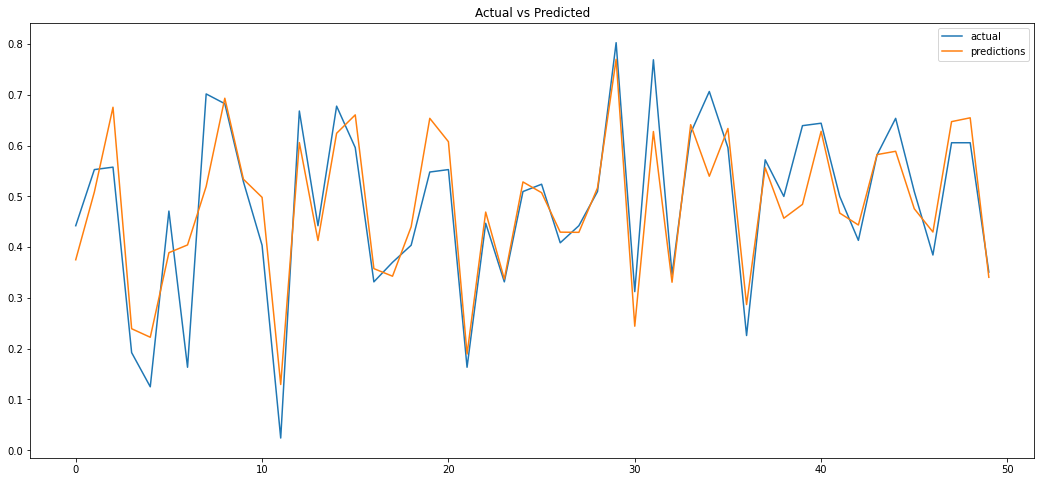

In [44]:
testingdata=test_df.head(50)
testingdata
create_plot(testingdata,forest,"Actual vs Predicted")

In [47]:
def create_score_table(y_test,y_pred):
    score_table = {"actual":[],"prediction":[]}
# 
    for i in y_test:
        actual = (round(int(263-55) * i + 55))
        score_table["actual"].append(actual)
    for i in y_pred:
        prediction = (round(int(263-55) * i + 55))
        score_table["prediction"].append(prediction)

    score_table = pd.DataFrame(score_table)
    score_table['difference'] = abs((score_table['actual']- score_table['prediction'])/score_table['actual']) * 100
#     
    return score_table

In [48]:
testingdata=test_df[0:50]
test_pred = random_forest_predictions(testingdata,forest)
test_y = testingdata['runs_x'].to_numpy().flatten()
pred_y = test_pred.to_numpy().flatten()

In [49]:
create_score_table(test_y,pred_y)

,actual,prediction,difference
0,147,133,9.523810
1,170,161,5.294118
2,171,196,14.619883
3,95,105,10.526316
4,81,101,24.691358
5,153,136,11.111111
6,89,139,56.179775
7,201,163,18.905473
8,197,199,1.015228
9,165,166,0.606061
